In [1]:
import os
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.join('..', '..'))

from numpy.linalg import norm

import analysis.plotting as pl
import modules.linear_algebra as lin
import modules.point_processing as pp

In [2]:
%matplotlib inline

In [3]:
"""Script to calculate gait metrics from Kinect data."""

import glob
import os

import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.cluster import MeanShift

import analysis.stats as st
import modules.gait_metrics as gm
import modules.numpy_funcs as nf

load_dir = os.path.join('..', '..', 'data', 'kinect', 'best_pos')
save_dir = os.path.join('..', '..', 'data', 'results')

save_name = 'kinect_gait_metrics.csv'

# All files with .pkl extension
file_paths = sorted(glob.glob(os.path.join(load_dir, '*.pkl')))
save_path = os.path.join(save_dir, save_name)

df_metrics = pd.read_csv(save_path, index_col=0)

for file_path in file_paths[:1]:

    df_head_feet = pd.read_pickle(file_path)
    frames = df_head_feet.index

    # Convert all points to floats to allow for future calculations (e.g. np.isnan)
    df_head_feet = df_head_feet.applymap(lambda point: point.astype(np.float))

    # Remove outliers
    dist_to_foot_l = (df_head_feet.HEAD - df_head_feet.L_FOOT).apply(norm)
    dist_to_foot_r = (df_head_feet.HEAD - df_head_feet.R_FOOT).apply(norm)

    to_filter = st.relative_error(
        dist_to_foot_l, dist_to_foot_r, absolute=True)
    filtered = st.mad_outliers(to_filter, 2)

    good_frames = np.unique(frames[~np.isnan(filtered)])
    keep_frame = np.in1d(frames, good_frames)

    df_head_feet = df_head_feet[keep_frame]
    frames = df_head_feet.index

    # Cluster frames with mean shift to locate the walking passes
    mean_shift = MeanShift(bandwidth=60).fit(nf.to_column(frames))
    labels = mean_shift.labels_
    
    # Sort labels so that the frames are in temporal order
    labels = nf.map_to_whole(labels)

    # DataFrames for each walking pass in a trial
    pass_dfs = list(nf.group_by_label(df_head_feet, labels))

In [4]:
df_pass = pass_dfs[0]

In [5]:
df_2d = df_pass.applymap(lambda point: np.array([point[2], point[0]]))

In [6]:
head_points = np.stack(df_2d.HEAD)
foot_points_1 = np.stack(df_2d.L_FOOT)
foot_points_2 = np.stack(df_2d.R_FOOT)



In [7]:
def estimate_direction(mean_foot_points):
        
    vectors = np.diff(mean_foot_points, axis=0)
    median_vector = np.median(vectors, axis=0)

    return lin.unit(median_vector)


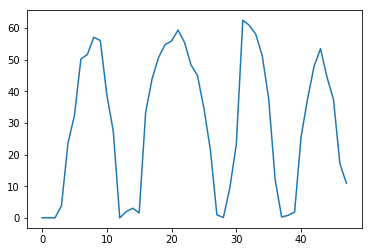

In [8]:
foot_dist = np.apply_along_axis(norm, 1, foot_points_1 - foot_points_2)
plt.plot(foot_dist)

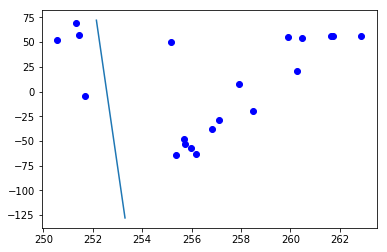

In [9]:
foot_points_a, foot_points_b = pp.track_two_objects(foot_points_1, foot_points_2)

mean_foot_points = (foot_points_1 + foot_points_2) / 2
direction_pass = estimate_direction(mean_foot_points)
line_point = np.median(mean_foot_points, axis=0)

plt.figure()

coeff = 100

# pl.scatter2(head_points, c='k')
pl.scatter2(foot_points_b[20:40, :], c='b')
# pl.scatter2(foot_points_b[:10, :], c='r')

pl.connect_points(line_point - coeff * direction_pass, 
                  line_point + coeff * direction_pass)
plt.show()